In [1]:
!unzip /content/Graph_cuts_processed_images.zip -d /content/Graph_cuts_processed_images


Streaming output truncated to the last 5000 lines.
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_6744.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_6747.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_6750.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_6756.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_676.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_6763.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_6765.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_677.jpeg  
  inflating: /content/Graph_cuts_processed_images/Graph_cuts_processed_images/ASD/ASD_0_678.jpeg  
  inflating: /content/Graph_cuts_processed_images/Gr

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you're using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Define the directory path for the extracted images
extracted_dir = '/content/Graph_cuts_processed_images/Graph_cuts_processed_images'

# Load the dataset
dataset = datasets.ImageFolder(extracted_dir, transform=transform)

# Print basic information about the dataset
print(f"Total images in dataset: {len(dataset)}")
print(f"Classes: {dataset.classes}")


Total images in dataset: 6485
Classes: ['ASD', 'Normal', 'PDA', 'VSD']


In [4]:
# Split the dataset into training and validation sets (80% train, 20% validate)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 5188
Validation set size: 1297


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

# Ensure you're using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained ResNet-152 model
model = models.resnet152(pretrained=True)

# Modify the final layer for our 4 classes
model.fc = nn.Linear(model.fc.in_features, 4)  # Output 4 classes

# Move the model to the chosen device
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds / total_preds
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    print("Training complete")
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Example usage:
# Assuming you have your DataLoader (train_loader) defined already.
trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

# Save the trained model
model_save_path = '/content/resnet152_trained_model.pth'
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 160MB/s]


Epoch 1/20
Training Loss: 0.9305, Training Accuracy: 0.5985
Epoch 2/20
Training Loss: 0.5027, Training Accuracy: 0.8065
Epoch 3/20
Training Loss: 0.2731, Training Accuracy: 0.9003
Epoch 4/20
Training Loss: 0.1287, Training Accuracy: 0.9561
Epoch 5/20
Training Loss: 0.1249, Training Accuracy: 0.9618
Epoch 6/20
Training Loss: 0.1846, Training Accuracy: 0.9345
Epoch 7/20
Training Loss: 0.0648, Training Accuracy: 0.9801
Epoch 8/20
Training Loss: 0.1101, Training Accuracy: 0.9607
Epoch 9/20
Training Loss: 0.0375, Training Accuracy: 0.9886
Epoch 10/20
Training Loss: 0.0245, Training Accuracy: 0.9929
Epoch 11/20
Training Loss: 0.0119, Training Accuracy: 0.9975
Epoch 12/20
Training Loss: 0.0686, Training Accuracy: 0.9813
Epoch 13/20
Training Loss: 0.1213, Training Accuracy: 0.9586
Epoch 14/20
Training Loss: 0.0394, Training Accuracy: 0.9867
Epoch 15/20
Training Loss: 0.0385, Training Accuracy: 0.9875
Epoch 16/20
Training Loss: 0.0615, Training Accuracy: 0.9794
Epoch 17/20
Training Loss: 0.0436

In [6]:
def evaluate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cohen_kappa = cohen_kappa_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        roc_auc = roc_auc_score(true_labels, predicted_labels, multi_class='ovr')
    except:
        roc_auc = 'Not Available'

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {cohen_kappa:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")

    # Only format ROC-AUC if it's not 'Not Available'
    if isinstance(roc_auc, str):
        print(f"ROC-AUC Score: {roc_auc}")
    else:
        print(f"ROC-AUC Score: {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ASD', 'VSD', 'PDA', 'Normal'], yticklabels=['ASD', 'VSD', 'PDA', 'Normal'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


Accuracy: 0.8234
Precision: 0.8235
Recall: 0.8234
F1 Score: 0.8222
Cohen's Kappa: 0.7617
Matthews Correlation Coefficient: 0.7625
ROC-AUC Score: Not Available


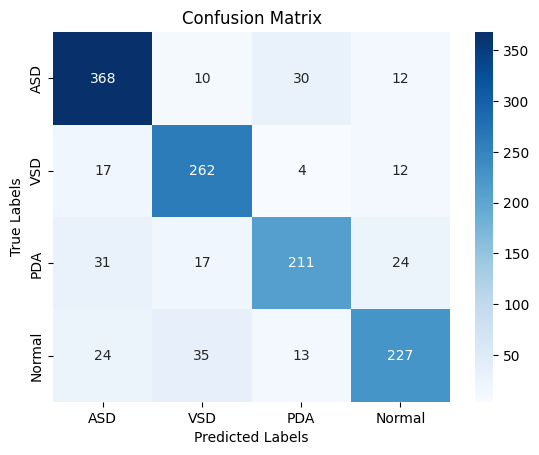

In [7]:
# Evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Call the evaluate_metrics function with the true and predicted labels
    evaluate_metrics(all_labels, all_preds)

# Evaluate the trained model
evaluate_model(trained_model, val_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Ensure you're using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained ResNet-152 model
model = models.resnet152(pretrained=True)

# Modify the final layer for our 4 classes
model.fc = nn.Linear(model.fc.in_features, 4)  # Output 4 classes

# Move the model to the chosen device
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function with loss and accuracy tracking
def train_model(model, train_loader, criterion, optimizer, num_epochs=15):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds / total_preds
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        # Append loss and accuracy for plotting
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

    print("Training complete")
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies

# Example usage:
# Assuming you have your DataLoader (train_loader) defined already.
num_epochs = 15
trained_model, train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# Save the trained model
model_save_path = '/content/resnet152_trained_model1.pth'
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plot training loss and accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Using device: cuda
Epoch 1/15
Training Loss: 0.9324, Training Accuracy: 0.5958
Epoch 2/15
Training Loss: 0.5340, Training Accuracy: 0.7982
Epoch 3/15
Training Loss: 0.2657, Training Accuracy: 0.9059
Epoch 4/15
